# Deep Learning入門

## Feedforward Neural Network(FNN) のサンプル

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


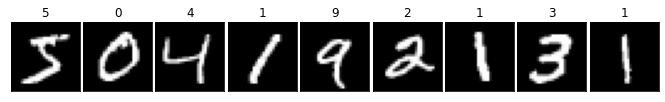

In [19]:
!pip install -qU keras

import matplotlib.pyplot as plt
from IPython.display import SVG
import seaborn

import numpy as np

from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import model_to_dot, to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

(x_train, y_train_nominal), (x_test, y_test_nominal) = mnist.load_data()
print(x_train.shape, y_train_nominal.shape)
print(x_test.shape, y_test_nominal.shape)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.5, hspace=0.05, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train_nominal[i]))
    ax.imshow(x_train[i], cmap='gray')

## 前処理

In [20]:
# 入力画像を行列(28x28)からベクトル(長さ784)に変換
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 名義尺度の値をone-hot表現へ変換
y_train = to_categorical(y_train_nominal)
y_test = to_categorical(y_test_nominal)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


## モデル作成

In [21]:
# Sequential: ネットワークを1列に積み上げているシンプルな方法
model = Sequential()

# 最初のlayerはinput_shapeを指定して、入力するデータの次元を与える必要がある
# Dense: 一般的な全結合層を表すレイヤー
# 初期化: Heの初期化法は活性化関数がReLUであるときに適している
model.add(Dense(units=1024, input_shape=(784,),
                kernel_initializer='he_uniform'))
# Activation: 活性化関数として relu を選択
model.add(Activation('relu'))

# 同時に指定も可能
model.add(Dense(1024, activation='relu'))

# ドロップアウト: 近似的にアンサンブル法を実現するもの
# ドロップアウトは入力の一部をランダムに0にして出力するlayerの一種。
# 訓練データセットから部分訓練データセットを大量に作成し、
# 各モデルの予測結果を平均する手法をアンサンブルというが、
# とてつもない計算量を要する
model.add(Dropout(0.15))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.15))

# 正規化: L2正則化では、全パラメータの2乗和を正則化項として損失関数に加えます。
# L2正則化では、パラメータを完全に0にすることは少ないものの、
# パラメータを滑らかにすることで予測精度のより良いモデルを構築する
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# 正規化: L1正則化では、全パラメータの絶対値の和を正則化項として損失関数に加える。
# L1正則化ではL2正則化よりもパラメータが0になりやすいという特徴（スパース性）がある
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(0.01)))

# 正規化: L1正則化とL2正則化の組み合わせのElasticNet
model.add(Dense(1024, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))

model.add(Dense(units=10))
# softmax: 他クラス分類の活性化関数として用いられる
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    # optimizer='sgd',
    # 最適化手法として Adam を使用している。
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
activation_3 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

## モデル可視化

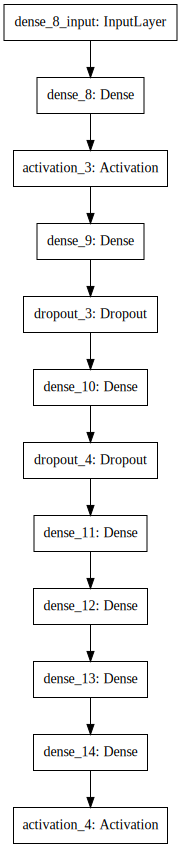

In [22]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

## モデル学習

In [23]:
history = model.fit(
    x_train, y_train,
    batch_size=32, epochs=10, verbose=1,
    validation_data=(x_test, y_test),
    # 早期終了: 検証データの誤差が大きくなってきた（或いは評価関数値が下がってきた）ところで学習をストップさせる
    #callbacks=[EarlyStopping(patience=3, verbose=1)]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 189us/step - loss: 31.0845 - accuracy: 0.9161 - val_loss: 2.3321 - val_accuracy: 0.9621
Epoch 2/10
60000/60000 [==============================] - 11s 184us/step - loss: 2.2976 - accuracy: 0.9637 - val_loss: 2.3250 - val_accuracy: 0.9611
Epoch 3/10
60000/60000 [==============================] - 11s 183us/step - loss: 2.3268 - accuracy: 0.9720 - val_loss: 2.3301 - val_accuracy: 0.9717
Epoch 4/10
60000/60000 [==============================] - 11s 191us/step - loss: 2.3321 - accuracy: 0.9776 - val_loss: 2.3415 - val_accuracy: 0.9737
Epoch 5/10
60000/60000 [==============================] - 11s 183us/step - loss: 2.3287 - accuracy: 0.9815 - val_loss: 2.3567 - val_accuracy: 0.9759
Epoch 6/10
60000/60000 [==============================] - 11s 183us/step - loss: 2.3647 - accuracy: 0.9832 - val_loss: 2.3155 - val_accuracy: 0.9810
Epoch 7/10
60000/60000 [==============================]

## モデル評価

Test loss: 2.418525285720825
Test accuracy: 0.9800999760627747


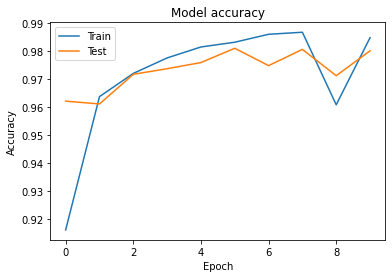

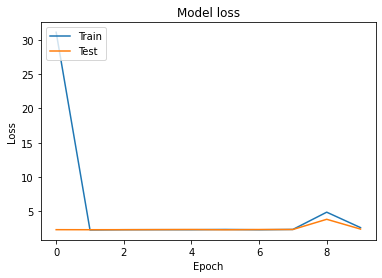

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 混同行列

(10000, 10)
(10000, 10)
Confusion Matrix
[[ 974    0   10    1    2    3    6    2    2    2]
 [   1 1120    0    0    2    0    2    1    1    3]
 [   0    1 1004    1    2    0    0    5    3    0]
 [   1    2    5  999    0    6    1    1    9    5]
 [   0    0    1    0  954    1    1    1    0    7]
 [   2    2    0    3    0  873    6    0    8    2]
 [   1    3    2    0   10    1  940    0    2    1]
 [   0    2    6    2    1    1    1 1015    5    3]
 [   0    5    4    2    2    4    1    0  939    3]
 [   1    0    0    2    9    3    0    3    5  983]]


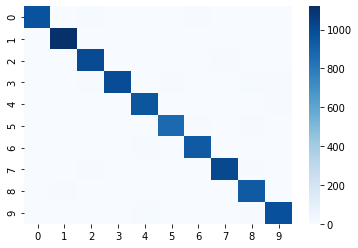

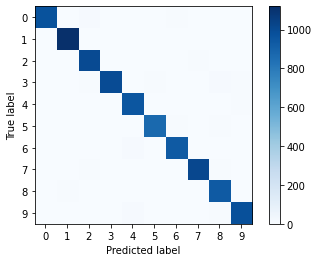

In [27]:
y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_test.shape)

cm = confusion_matrix(np.argmax(y_pred, axis=1), y_test_nominal)

display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print('Confusion Matrix')
print(cm)
seaborn.heatmap(cm, cmap='Blues')

cmd = ConfusionMatrixDisplay(cm, display_labels)
cmd.plot(include_values=False, cmap=plt.cm.Blues)